# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [30]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MNIST Dataset


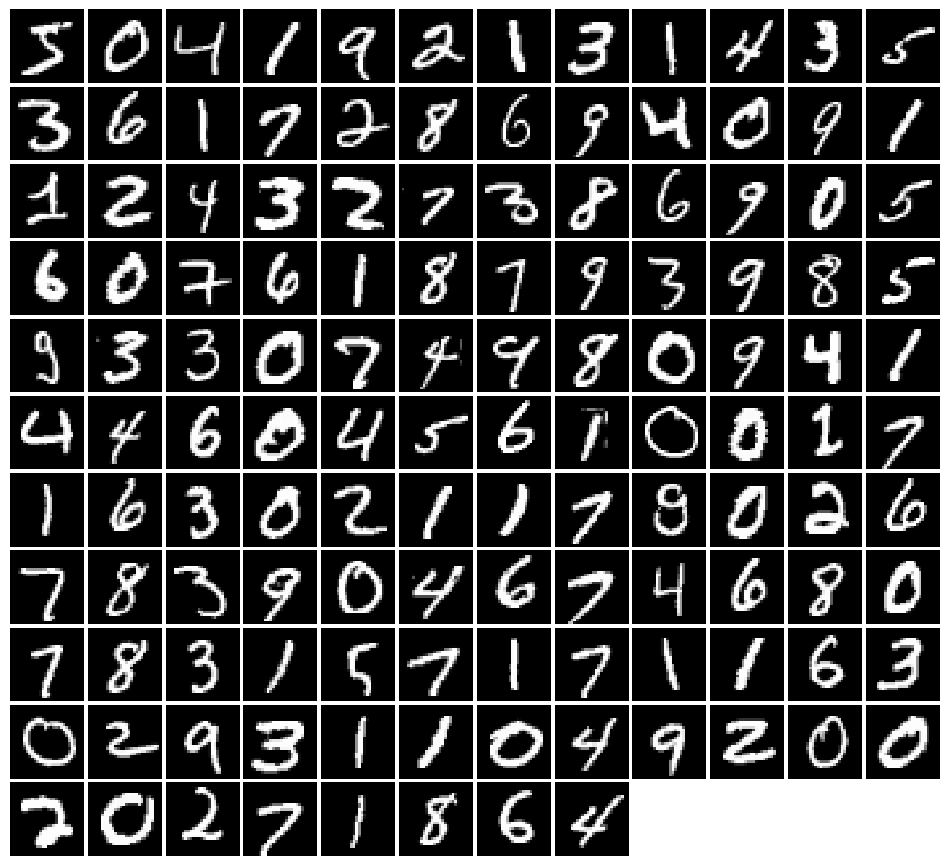

In [33]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = next(iter(loader_train))[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [34]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [35]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [36]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.391, G:0.6988


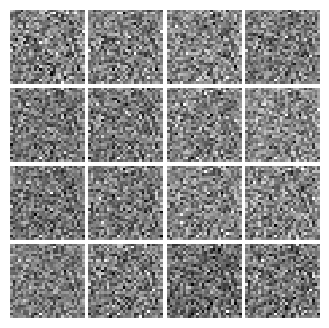


Iter: 250, D: 0.7957, G:1.189


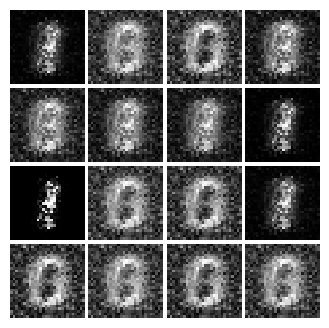


EPOCH:  2
Iter: 500, D: 0.9511, G:1.93


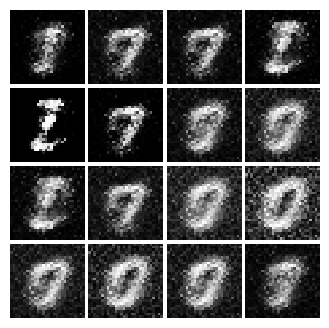


Iter: 750, D: 1.173, G:1.191


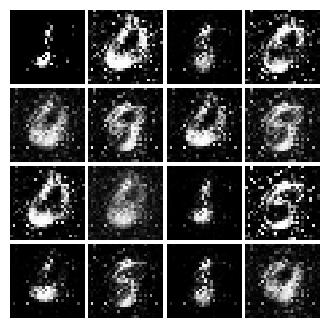


EPOCH:  3
Iter: 1000, D: 1.201, G:1.115


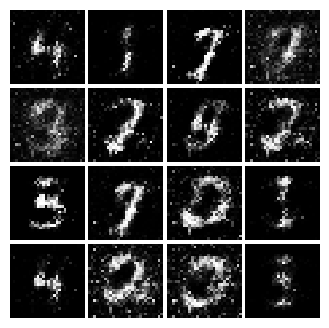


Iter: 1250, D: 0.9313, G:1.273


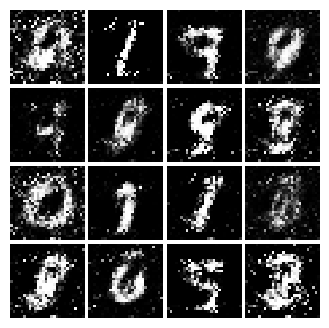


EPOCH:  4
Iter: 1500, D: 1.145, G:1.035


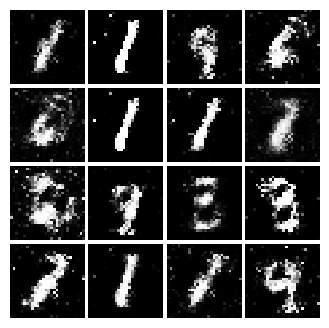


Iter: 1750, D: 1.183, G:1.078


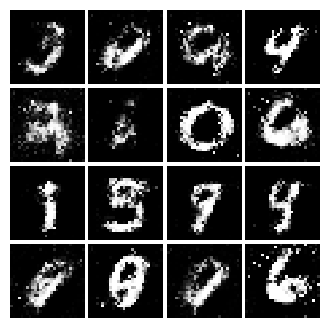


EPOCH:  5
Iter: 2000, D: 1.199, G:0.8615


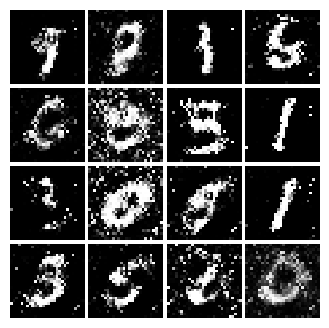


Iter: 2250, D: 1.306, G:1.047


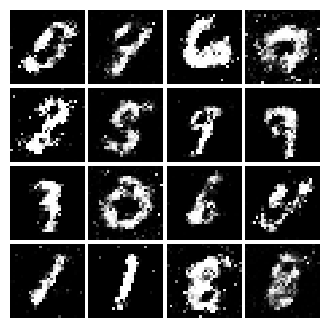


EPOCH:  6
Iter: 2500, D: 1.298, G:0.8705


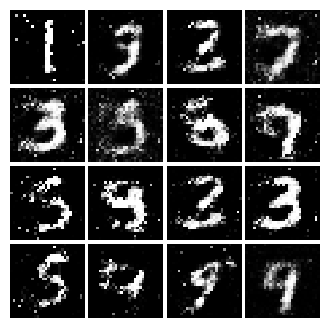


Iter: 2750, D: 1.353, G:0.9943


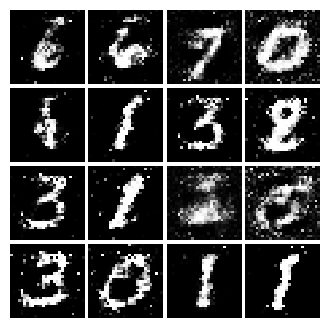


EPOCH:  7
Iter: 3000, D: 1.297, G:0.9179


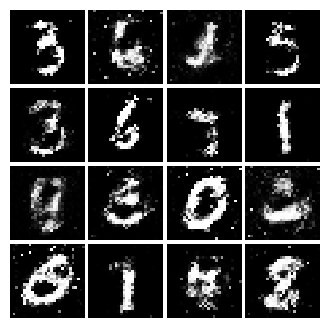


Iter: 3250, D: 1.263, G:0.9869


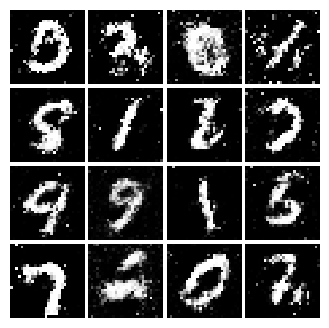


EPOCH:  8
Iter: 3500, D: 1.354, G:0.7449


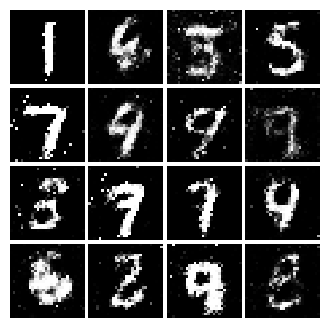


EPOCH:  9
Iter: 3750, D: 1.335, G:0.7613


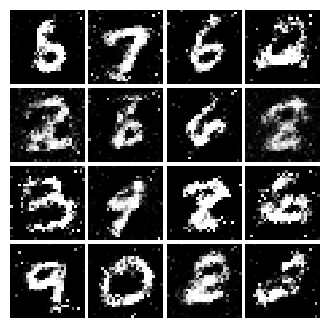


Iter: 4000, D: 1.298, G:0.6967


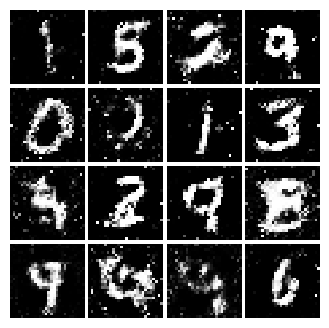


EPOCH:  10
Iter: 4250, D: 1.298, G:0.8284


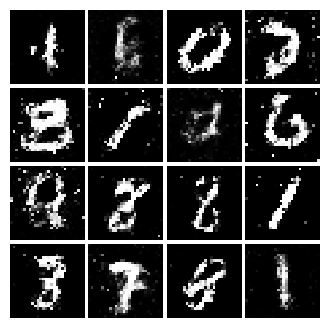


Iter: 4500, D: 1.281, G:0.9466


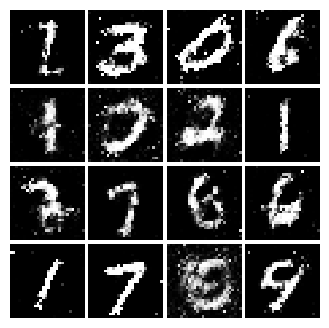

In [41]:
from gan.models import Discriminator, Generator
# # original GAN
D = discriminator().to(device)
G = generator().to(device)

# DCGAN
# D = Discriminator().to(device)
# G = Generator(noise_dim=NOISE_DIM).to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.3625, G:0.4205


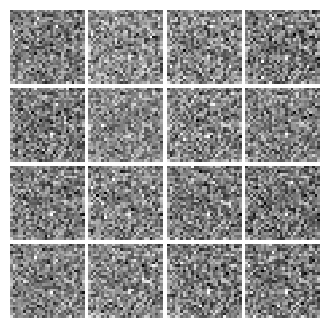


Iter: 250, D: 0.1152, G:0.3872


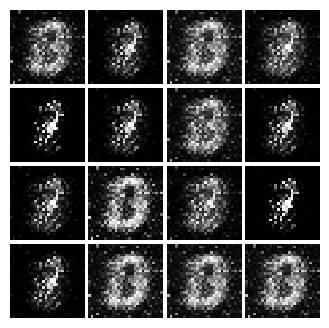


EPOCH:  2
Iter: 500, D: 0.1777, G:0.09482


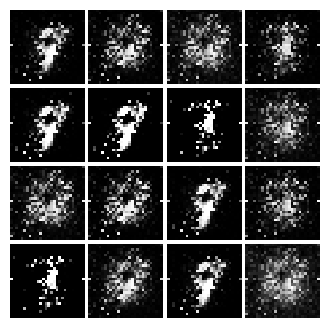


Iter: 750, D: 0.162, G:0.7239


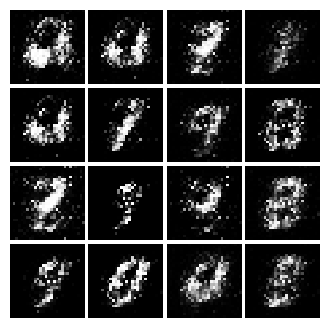


EPOCH:  3
Iter: 1000, D: 0.1977, G:0.2887


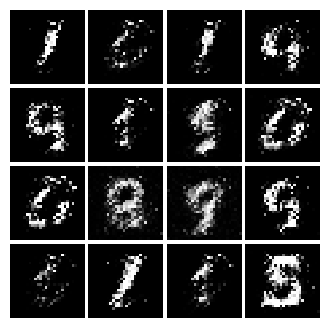


Iter: 1250, D: 0.1956, G:0.1928


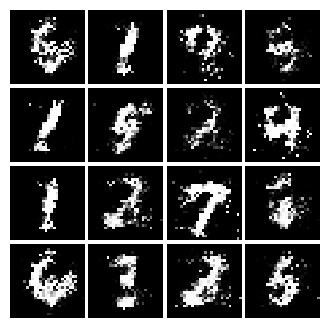


EPOCH:  4
Iter: 1500, D: 0.1855, G:0.2882


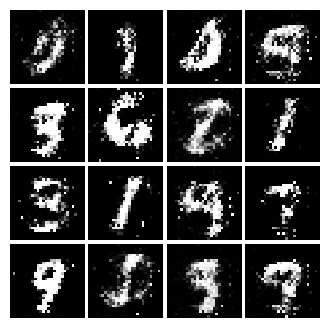


Iter: 1750, D: 0.1949, G:0.1863


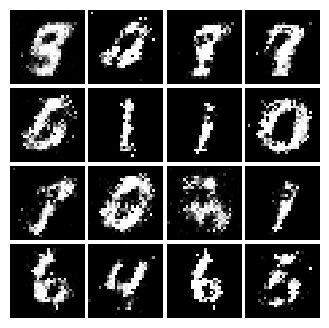


EPOCH:  5
Iter: 2000, D: 0.1772, G:0.1782


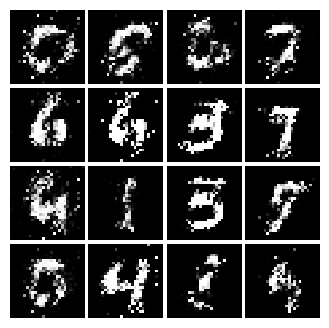


Iter: 2250, D: 0.2159, G:0.1714


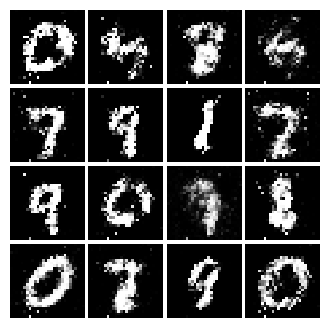


EPOCH:  6
Iter: 2500, D: 0.1975, G:0.1833


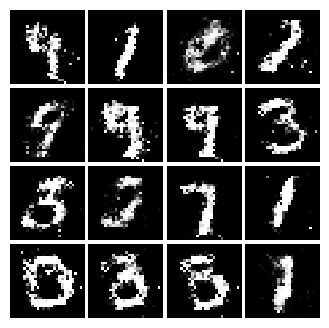


Iter: 2750, D: 0.237, G:0.1695


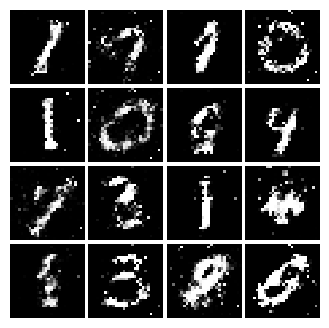


EPOCH:  7
Iter: 3000, D: 0.2353, G:0.1757


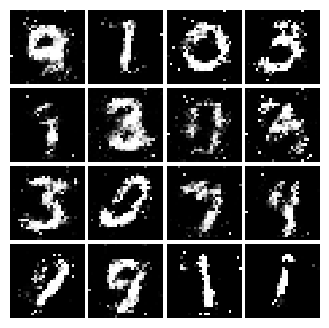


Iter: 3250, D: 0.2351, G:0.189


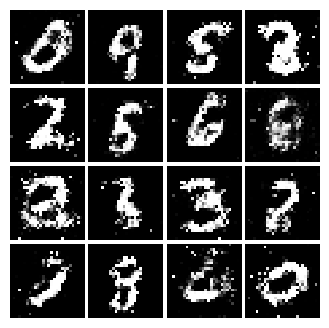


EPOCH:  8
Iter: 3500, D: 0.2287, G:0.1718


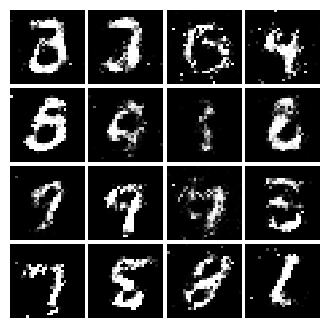


EPOCH:  9
Iter: 3750, D: 0.2211, G:0.1621


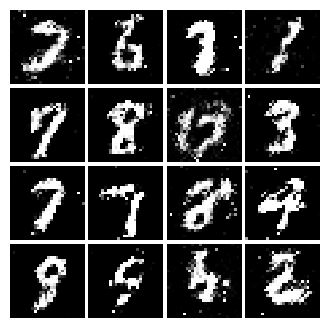


Iter: 4000, D: 0.2424, G:0.134


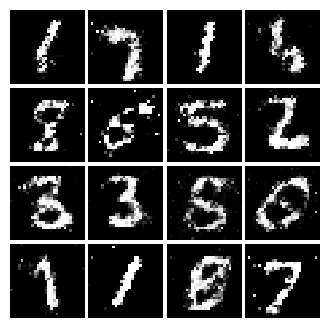


EPOCH:  10
Iter: 4250, D: 0.22, G:0.2057


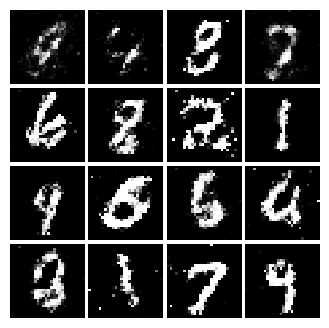


Iter: 4500, D: 0.2298, G:0.1546


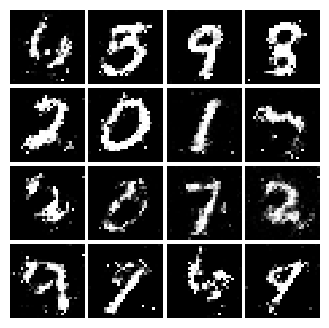

In [29]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)